# Project 6: D(St)reams of Anomalies
## Import Libraries
Import useful libraries and ML models

In [1]:
#libraries
import numpy as np
import pandas as pd
from numpy import sum, int64, linalg, array

from matplotlib import pyplot
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter, WeekdayLocator, drange, RRuleLocator, YEARLY, rrulewrapper, MonthLocator
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist 

#model
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

#ignore warnings
import warnings
warnings.filterwarnings("ignore") 

## Load Data, Observe Data and Data Cleanning
Source: https://www.kaggle.com/boltzmannbrain/nab
<br>
We use different function to take a look at basic information about dataset. we notice there are only two feature in this dataset. They are time and values. we checked null column.

In [2]:
CPU_df = pd.read_csv("Data\\CUAM.csv")
print(CPU_df.head())
print("\nBasic Info")
print(CPU_df.info())
print(CPU_df.describe())
print("\nCheck Null")
print(CPU_df.isnull().sum())

             timestamp   value
0  2014-05-14 01:14:00  85.835
1  2014-05-14 01:19:00  88.167
2  2014-05-14 01:24:00  44.595
3  2014-05-14 01:29:00  56.282
4  2014-05-14 01:34:00  36.534

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  18050 non-null  object 
 1   value      18050 non-null  float64
dtypes: float64(1), object(1)
memory usage: 211.6+ KB
None
              value
count  18050.000000
mean      38.282756
std       15.639294
min       11.529000
25%       30.789000
50%       32.001000
75%       35.660500
max      100.000000

Check Null
timestamp    0
value        0
dtype: int64


We convert timestamp to datetime value and we make a new row called second to convert time to second, so we have more feature that can be used.

In [3]:
CPU_df['timestamp'] = pd.to_datetime(CPU_df['timestamp'])
CPU_df['second']= (CPU_df.timestamp.astype(np.int64)/10**9).astype(np.int64)
CPU_df.head()

,timestamp,value,second
0,2014-05-14 01:14:00,85.835,1400030040
1,2014-05-14 01:19:00,88.167,1400030340
2,2014-05-14 01:24:00,44.595,1400030640
3,2014-05-14 01:29:00,56.282,1400030940
4,2014-05-14 01:34:00,36.534,1400031240


We plot the data to see the pattern

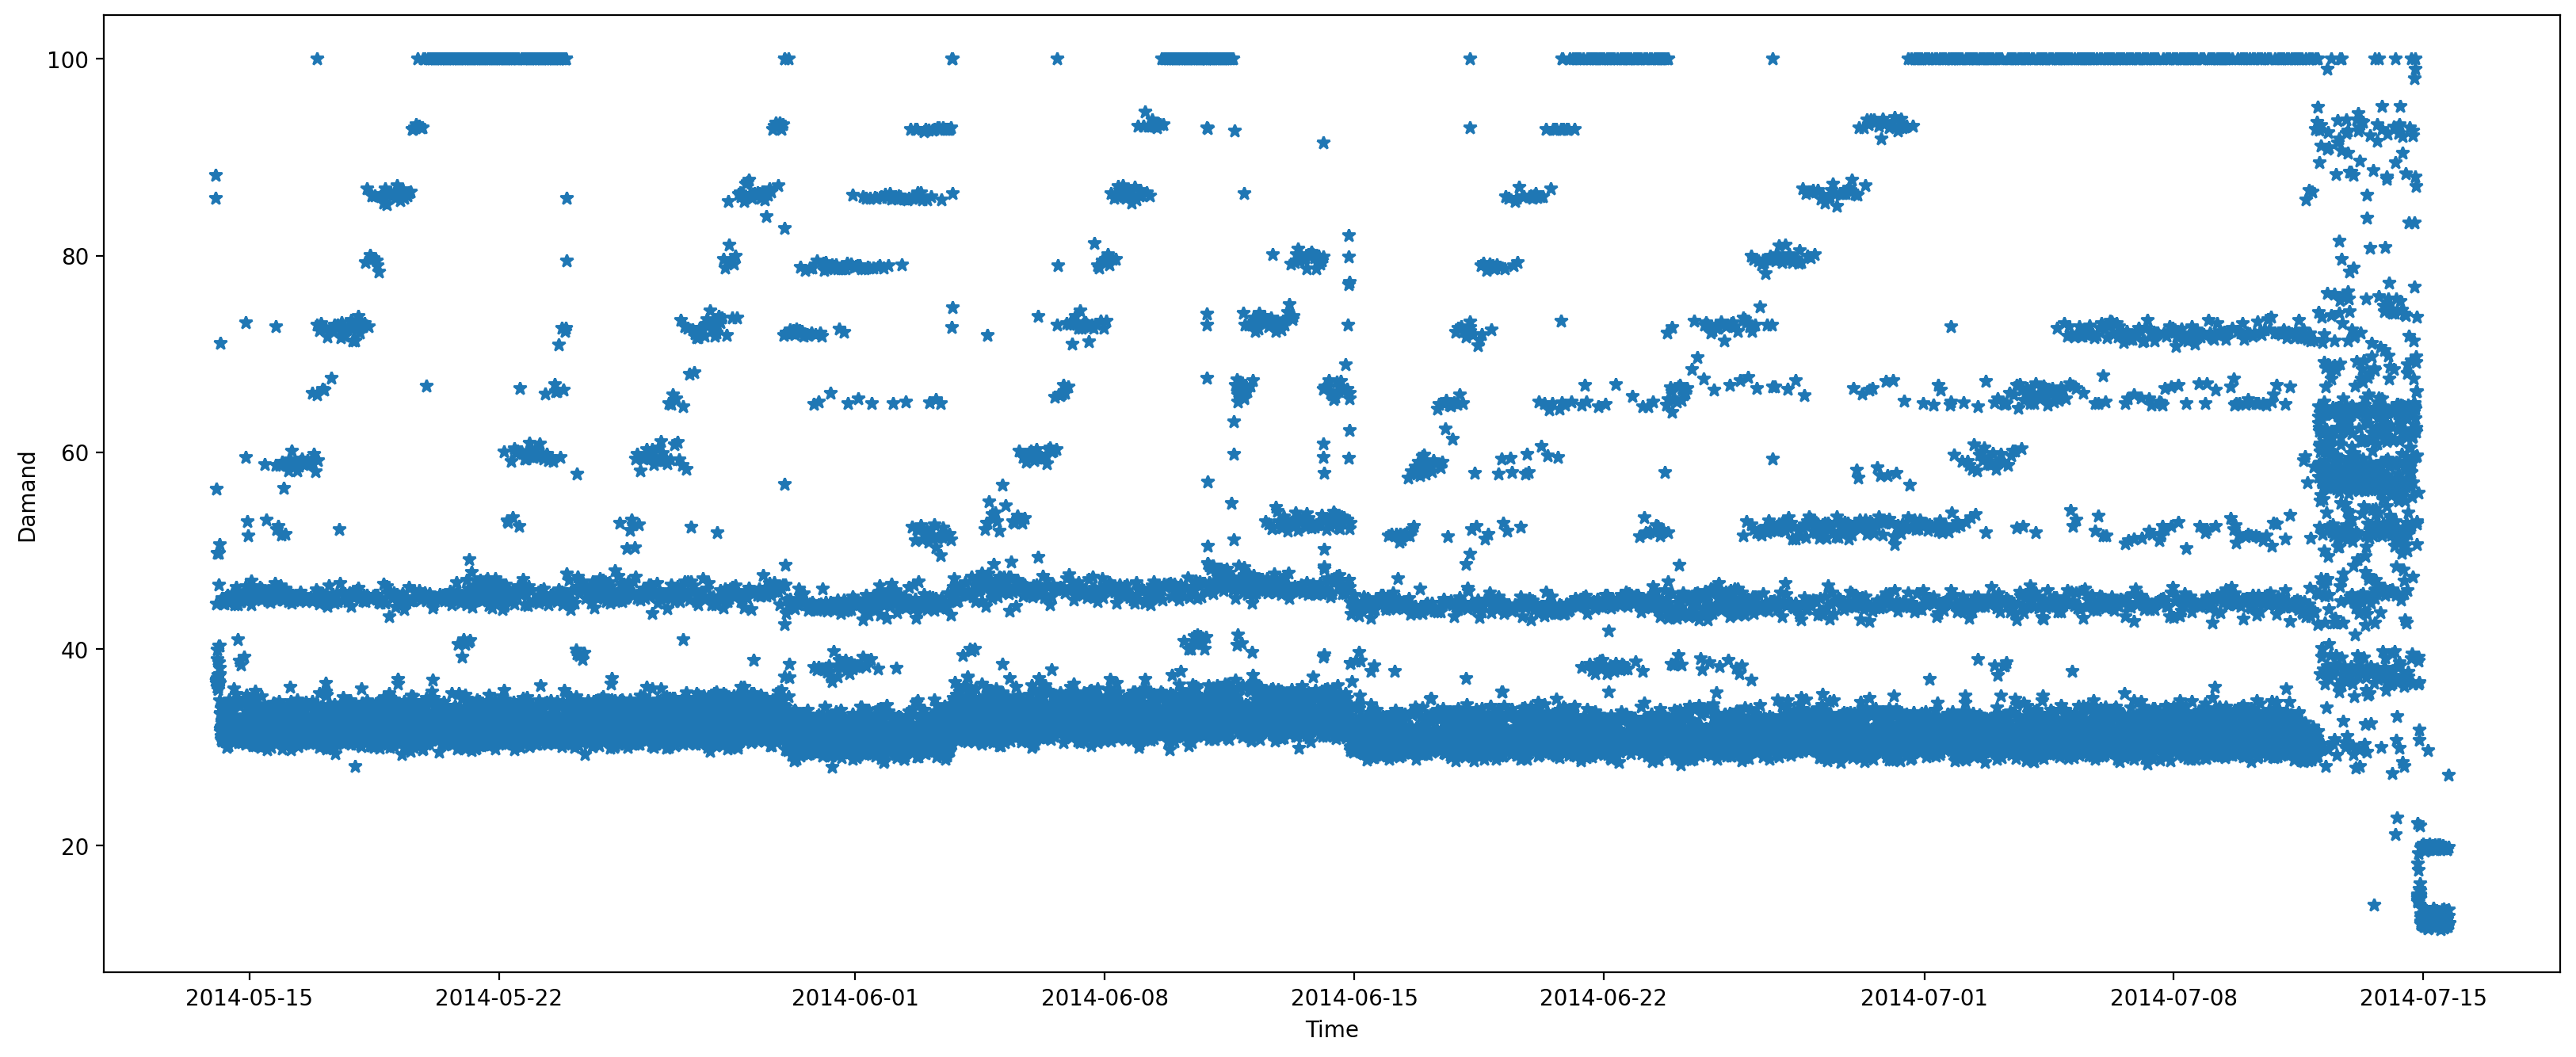

In [4]:
pyplot.figure(figsize=(20,8),dpi=200)
pyplot.plot(CPU_df['timestamp'],CPU_df['value'],"*")
pyplot.xlabel('Time')
pyplot.ylabel('Damand')
pyplot.show()

We noticed that the temperature are mostly higher than 20C and less than 50C. The data near 2014-07-15 are very different than the data before that day. The CPU temperature are not often lower than 30C which could be a anomal data. We can also observe the CPU with temperature at 100C are rare happen.  

## Isolation Forest


In [5]:
X = CPU_df.loc[:,['second','value']]
a = np.array(X.value.tolist()).reshape(-1, 1)
b = np.array(X.second.tolist()).reshape(-1, 1)

In [6]:
model = IsolationForest(random_state=0, contamination=0.01)
model.fit(X)
prediction = model.predict(X)
CPU_df['IsolationForest_Anomaly'] =prediction
CPU_df.head()

,timestamp,value,second,IsolationForest_Anomaly
0,2014-05-14 01:14:00,85.835,1400030040,-1
1,2014-05-14 01:19:00,88.167,1400030340,-1
2,2014-05-14 01:24:00,44.595,1400030640,1
3,2014-05-14 01:29:00,56.282,1400030940,1
4,2014-05-14 01:34:00,36.534,1400031240,1


### Plot Graph

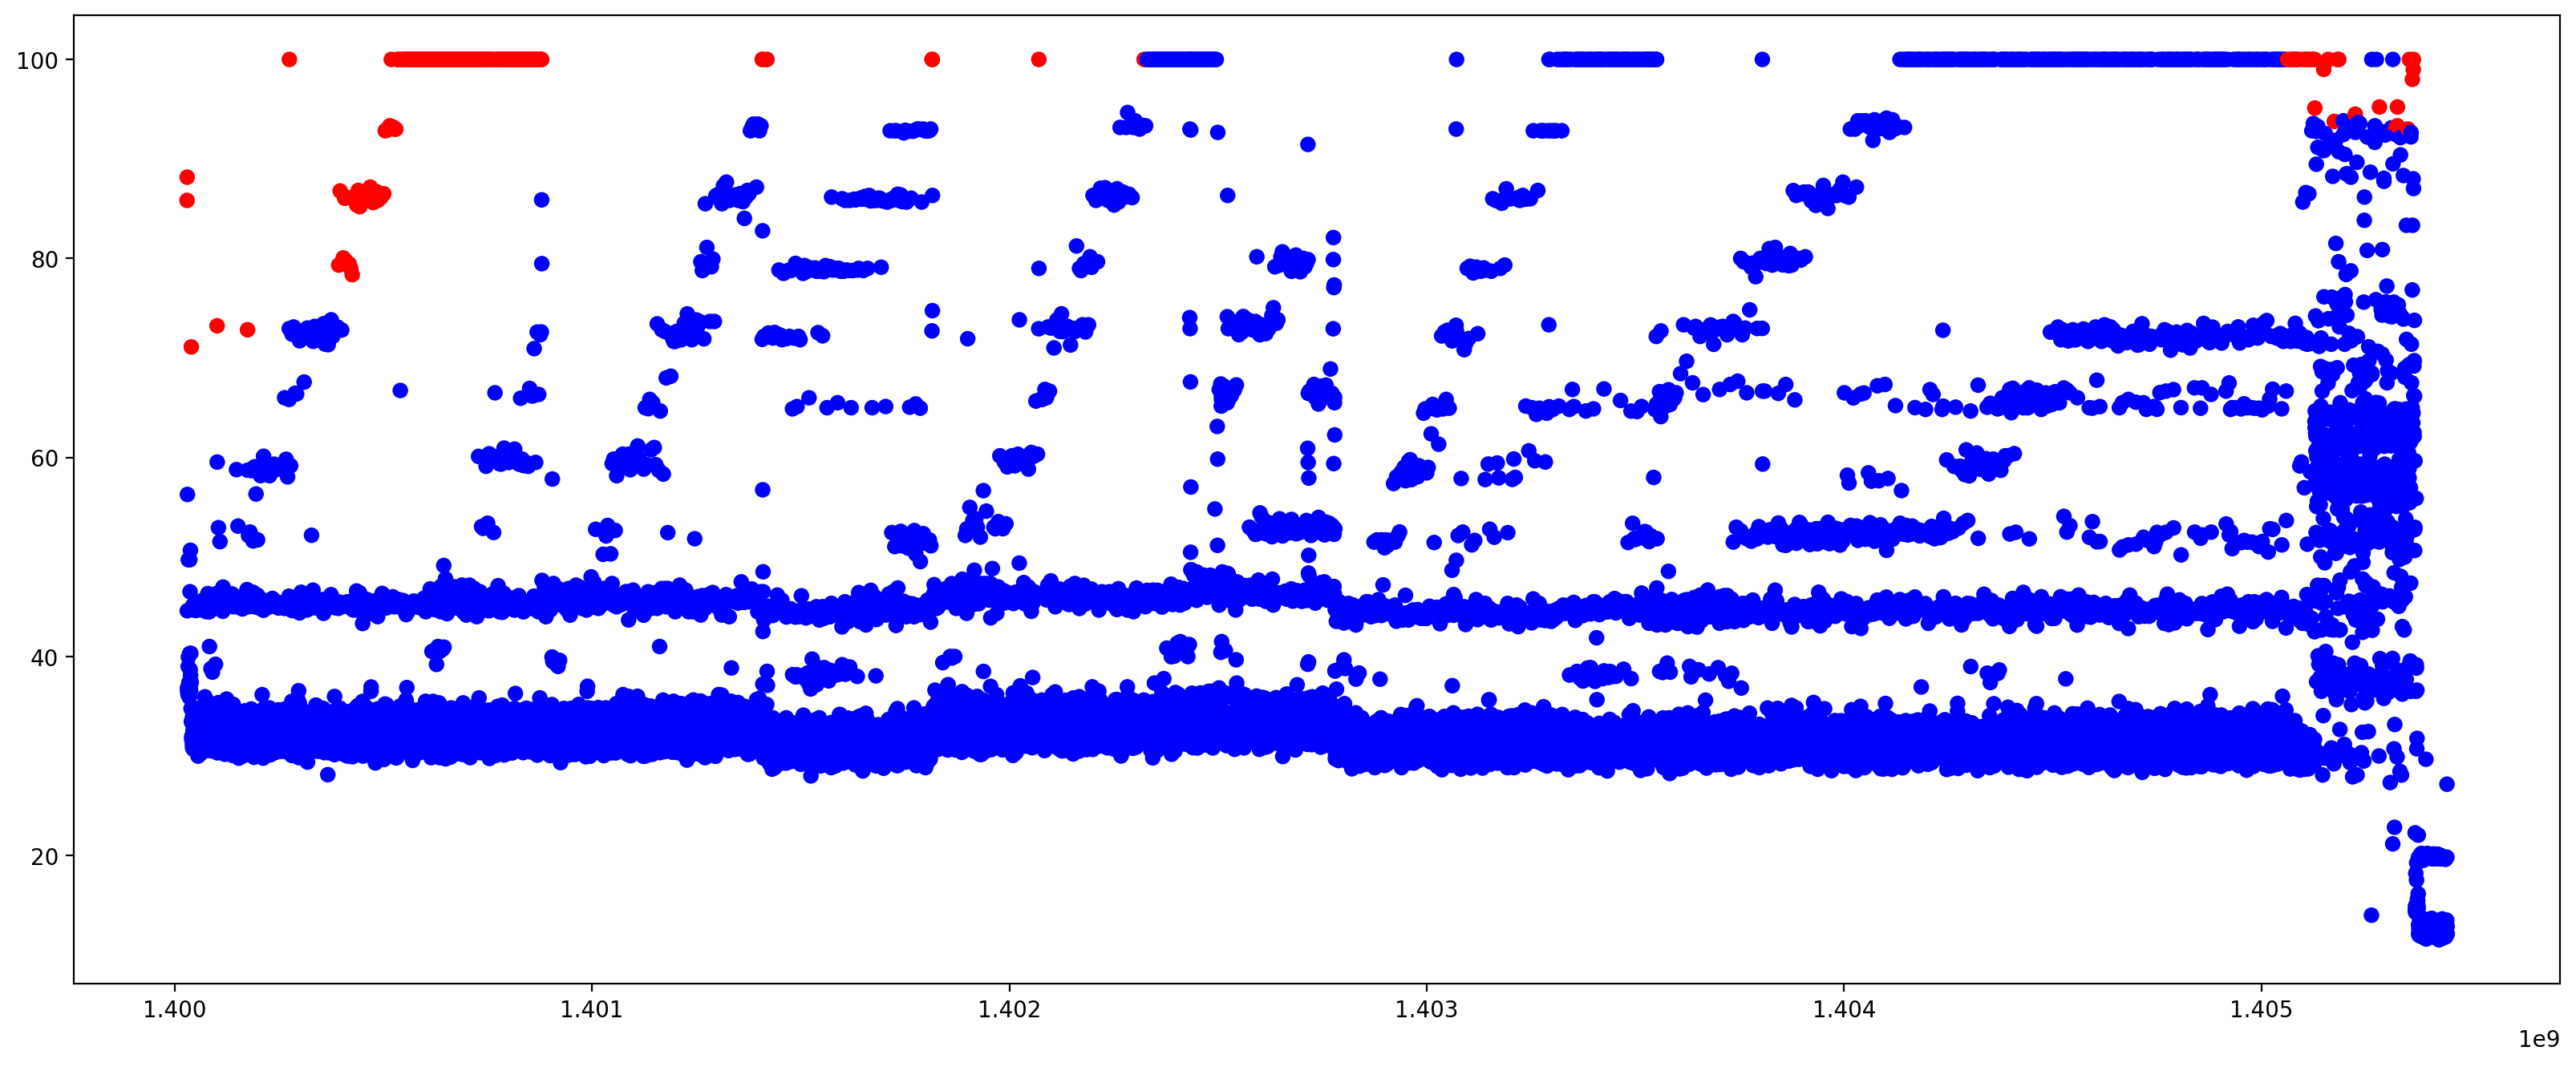

In [7]:
pyplot.figure(figsize=(20,8),dpi=200)
colors = np.array(list(map(lambda x: "red" if x == -1 else "blue", prediction)))
pyplot.scatter(b, a, c=colors)
pyplot.show()

In [8]:
anomaly = len(CPU_df.loc[CPU_df['IsolationForest_Anomaly']==-1])
print('Number of anomaly: {}'.format(anomaly))
print('Percentage of anomalies in data:{}'.format(anomaly*100/len(CPU_df)))

Number of anomaly: 177
Percentage of anomalies in data:0.9806094182825484


The result is pretty good. we only have 0.98% anomaly data in whole dataset. However, this is base on one model, we will take a look at other model to compare them.

## KMean 
Standard the data

In [9]:
scaled_data = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(scaled_data)

Trying to get Elbow curve to see how many distortion and inertial would be good for this model.

In [10]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

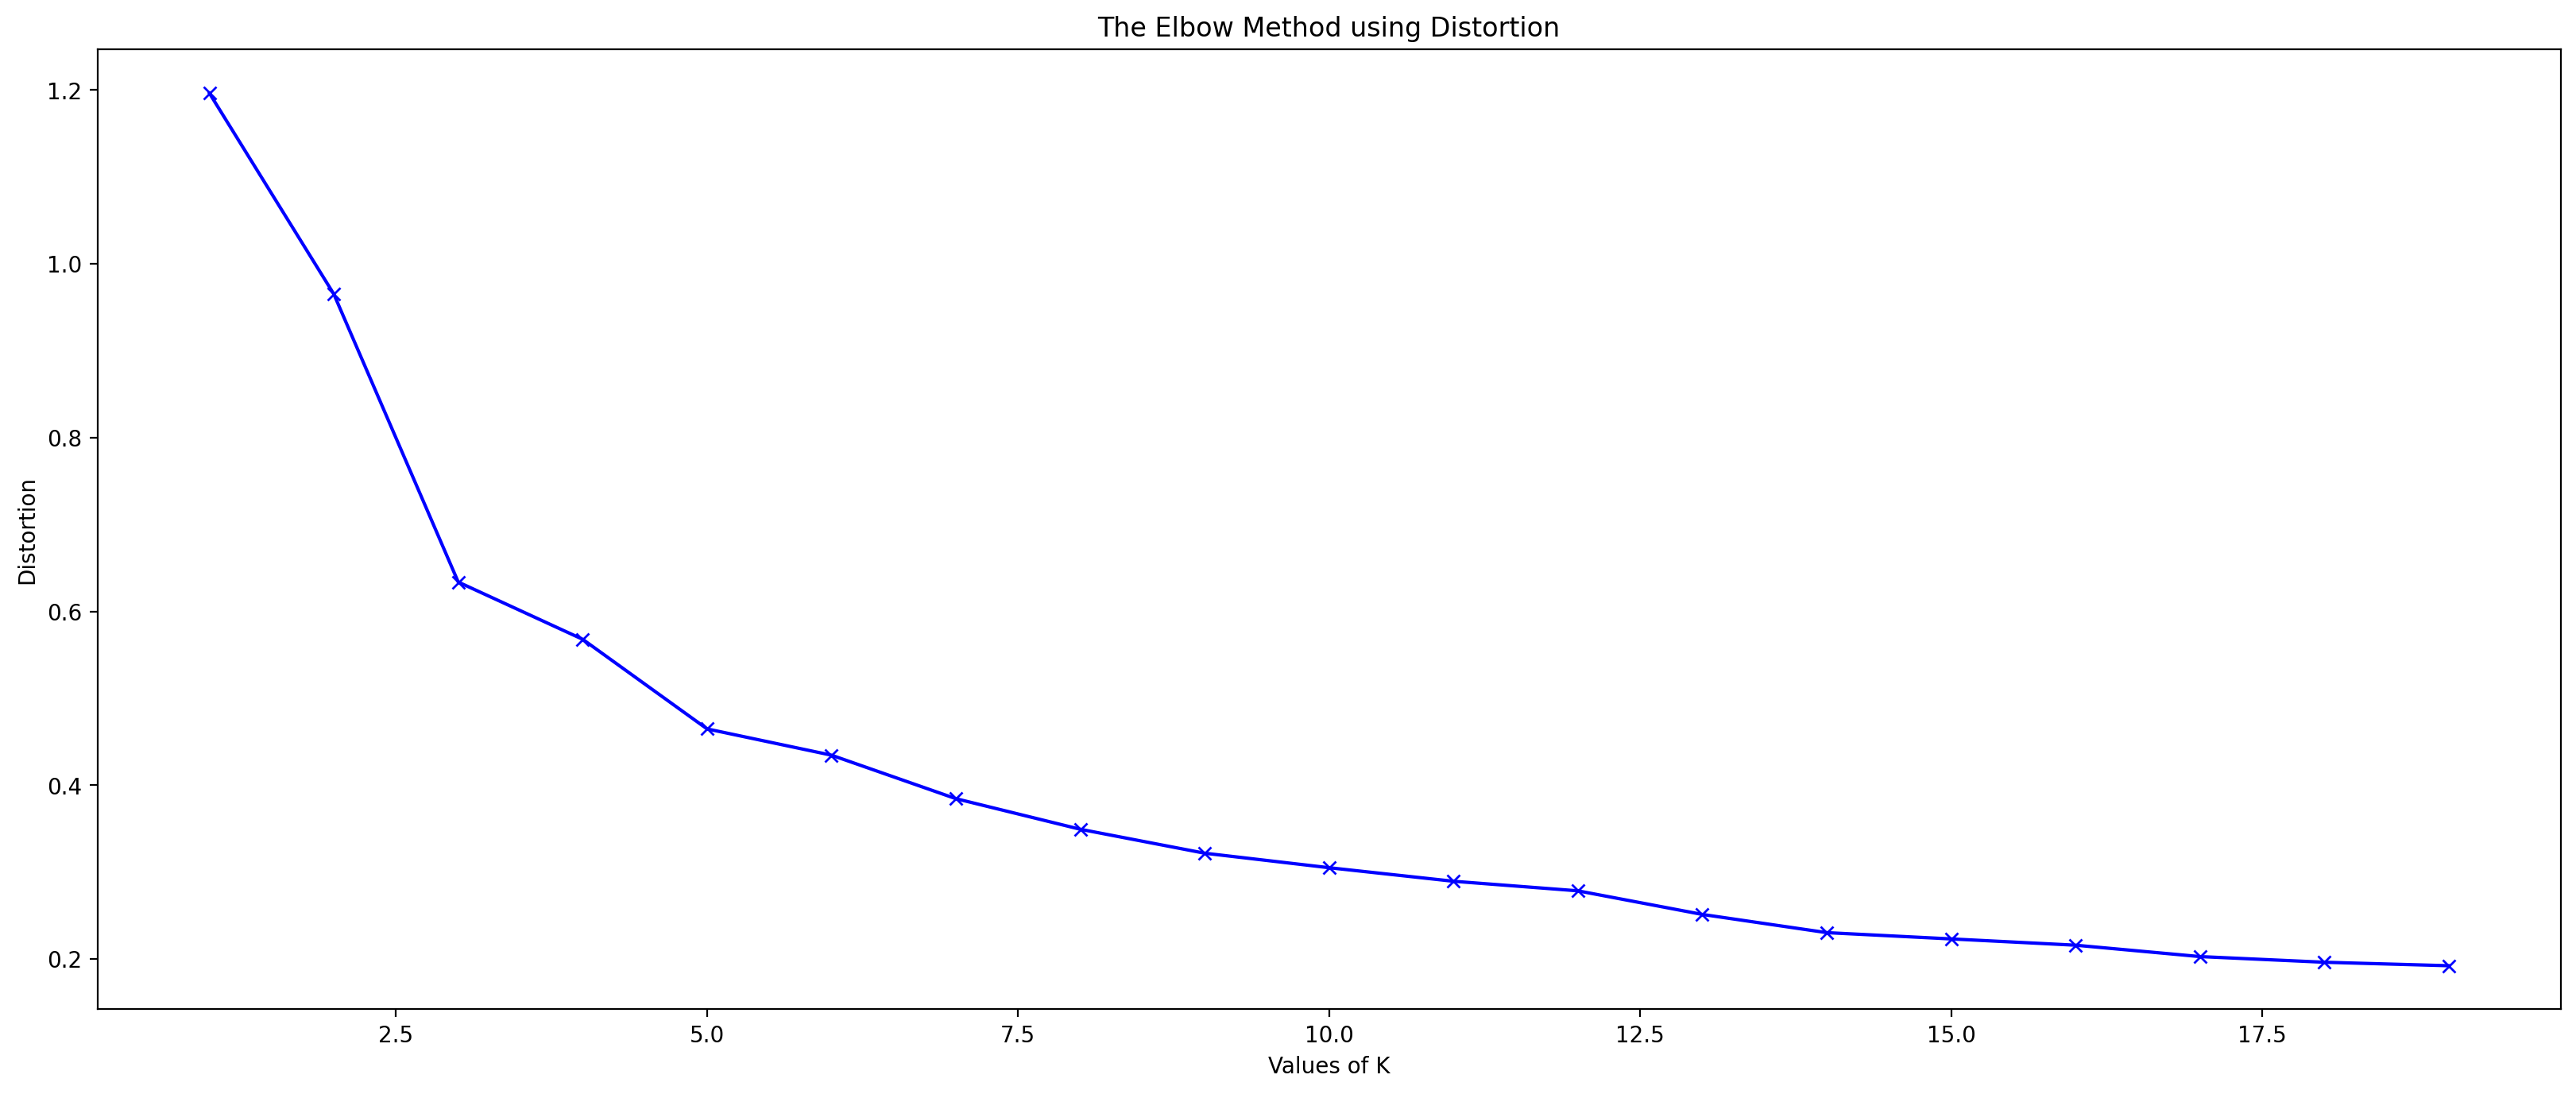

In [11]:
pyplot.figure(figsize=(20,8),dpi=200)
pyplot.plot(K, distortions, 'bx-') 
pyplot.xlabel('Values of K') 
pyplot.ylabel('Distortion') 
pyplot.title('The Elbow Method using Distortion') 
pyplot.show() 

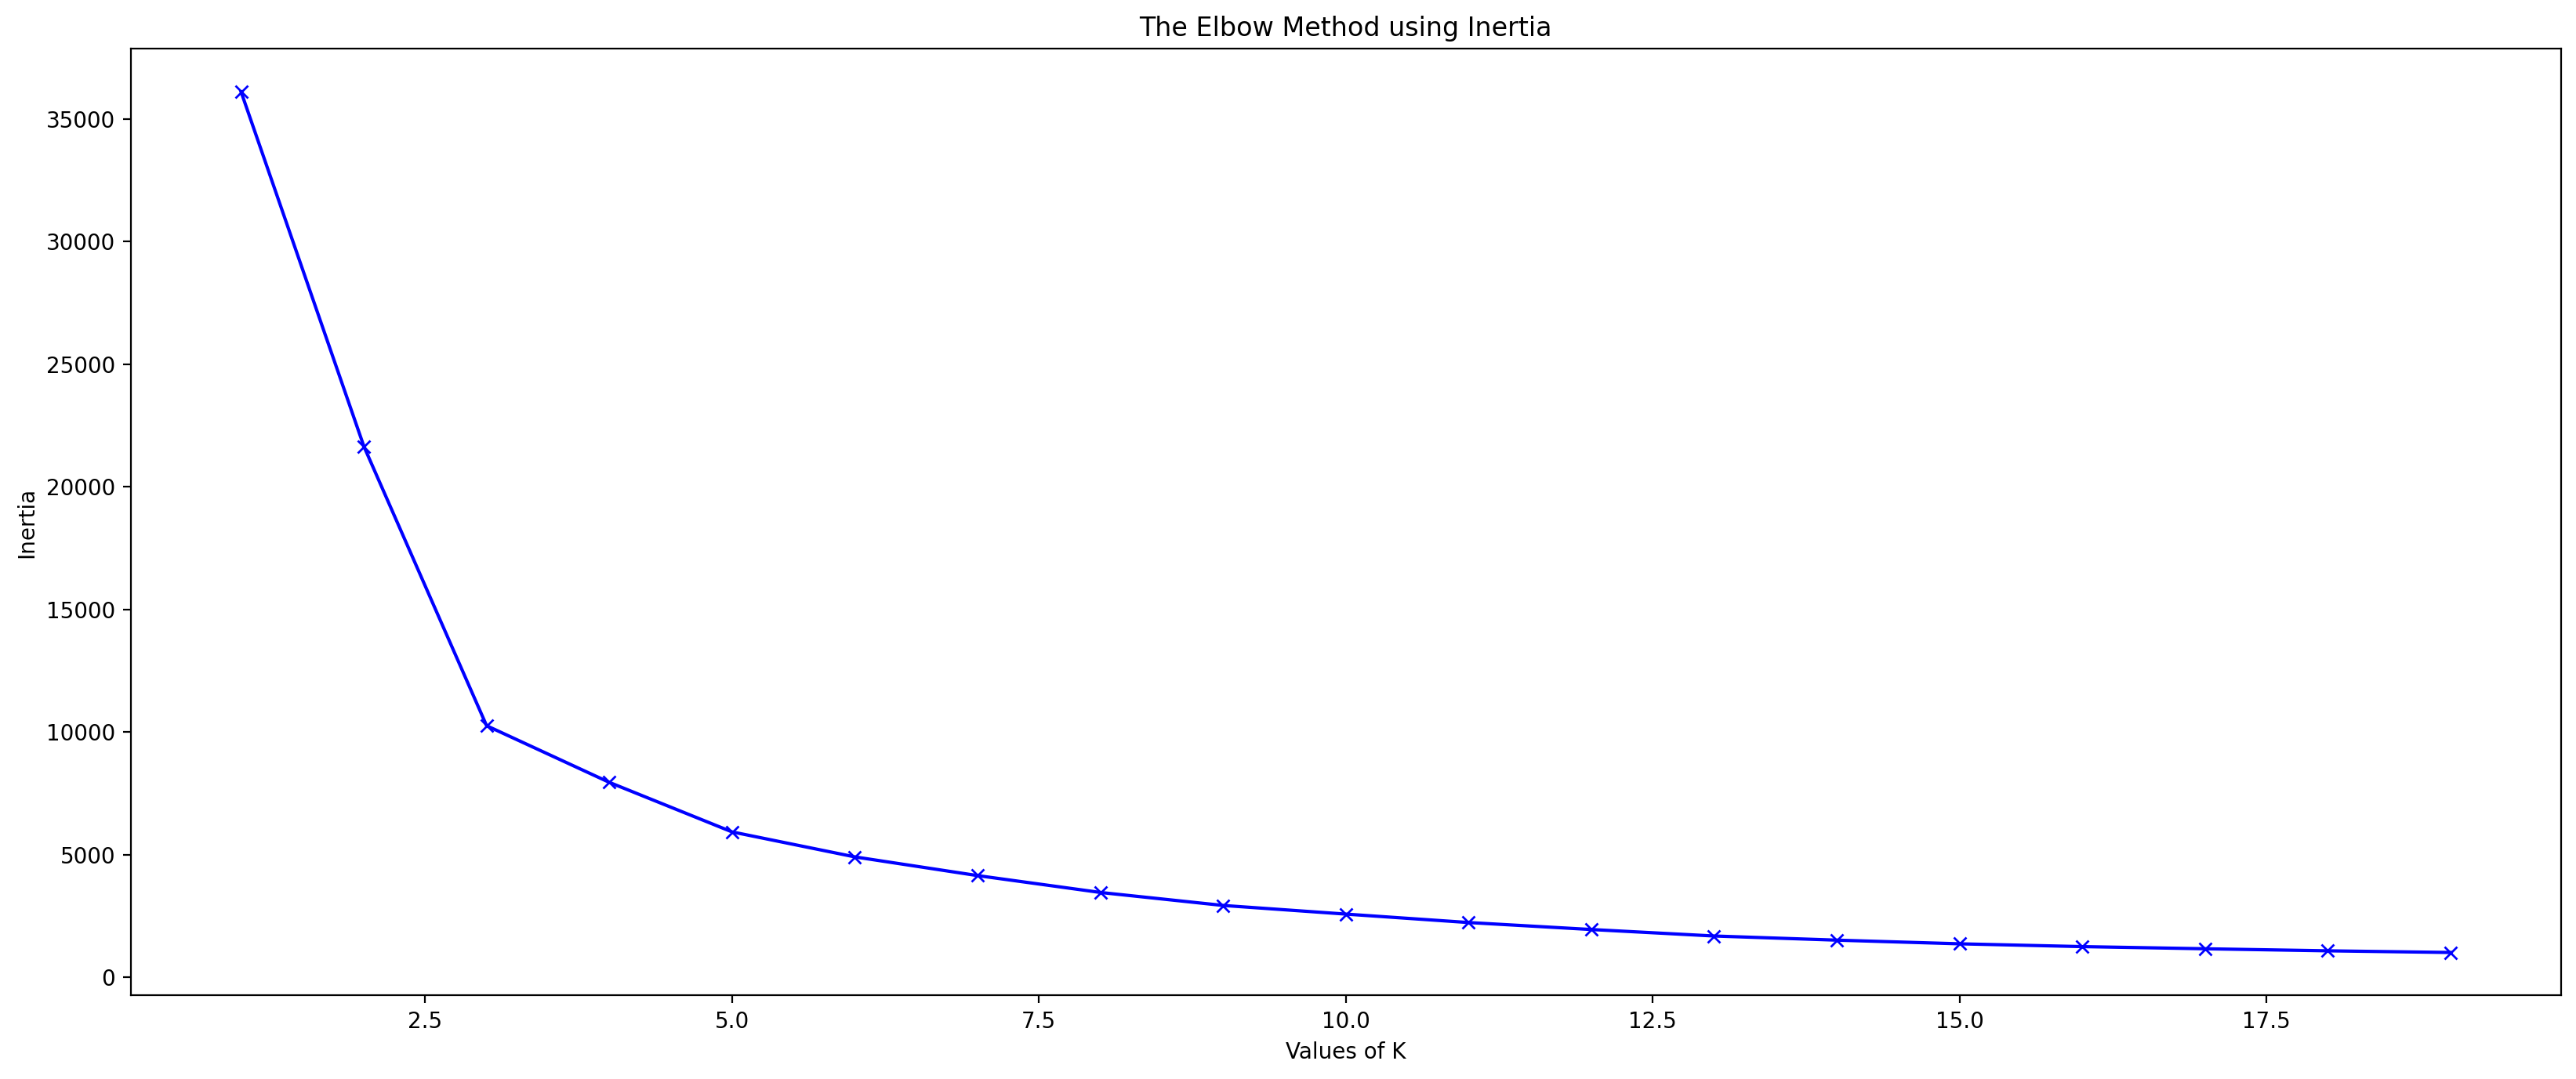

In [12]:
pyplot.figure(figsize=(20,8),dpi=200)
pyplot.plot(K, inertias, 'bx-') 
pyplot.xlabel('Values of K') 
pyplot.ylabel('Inertia') 
pyplot.title('The Elbow Method using Inertia') 
pyplot.show()

The best distortion socre for K is 5 and the best inertial score for K is 4.

Train the model

In [13]:
bestkmeans = KMeans(n_clusters= 5, n_init=4)
clusters=bestkmeans.fit_predict(X)
CPU_df["KMean_Cluster"] = bestkmeans.predict(X)
CPU_df.head()

,timestamp,value,second,IsolationForest_Anomaly,KMean_Cluster
0,2014-05-14 01:14:00,85.835,1400030040,-1,4
1,2014-05-14 01:19:00,88.167,1400030340,-1,4
2,2014-05-14 01:24:00,44.595,1400030640,1,0
3,2014-05-14 01:29:00,56.282,1400030940,1,0
4,2014-05-14 01:34:00,36.534,1400031240,1,3


Plot the cluster distribution

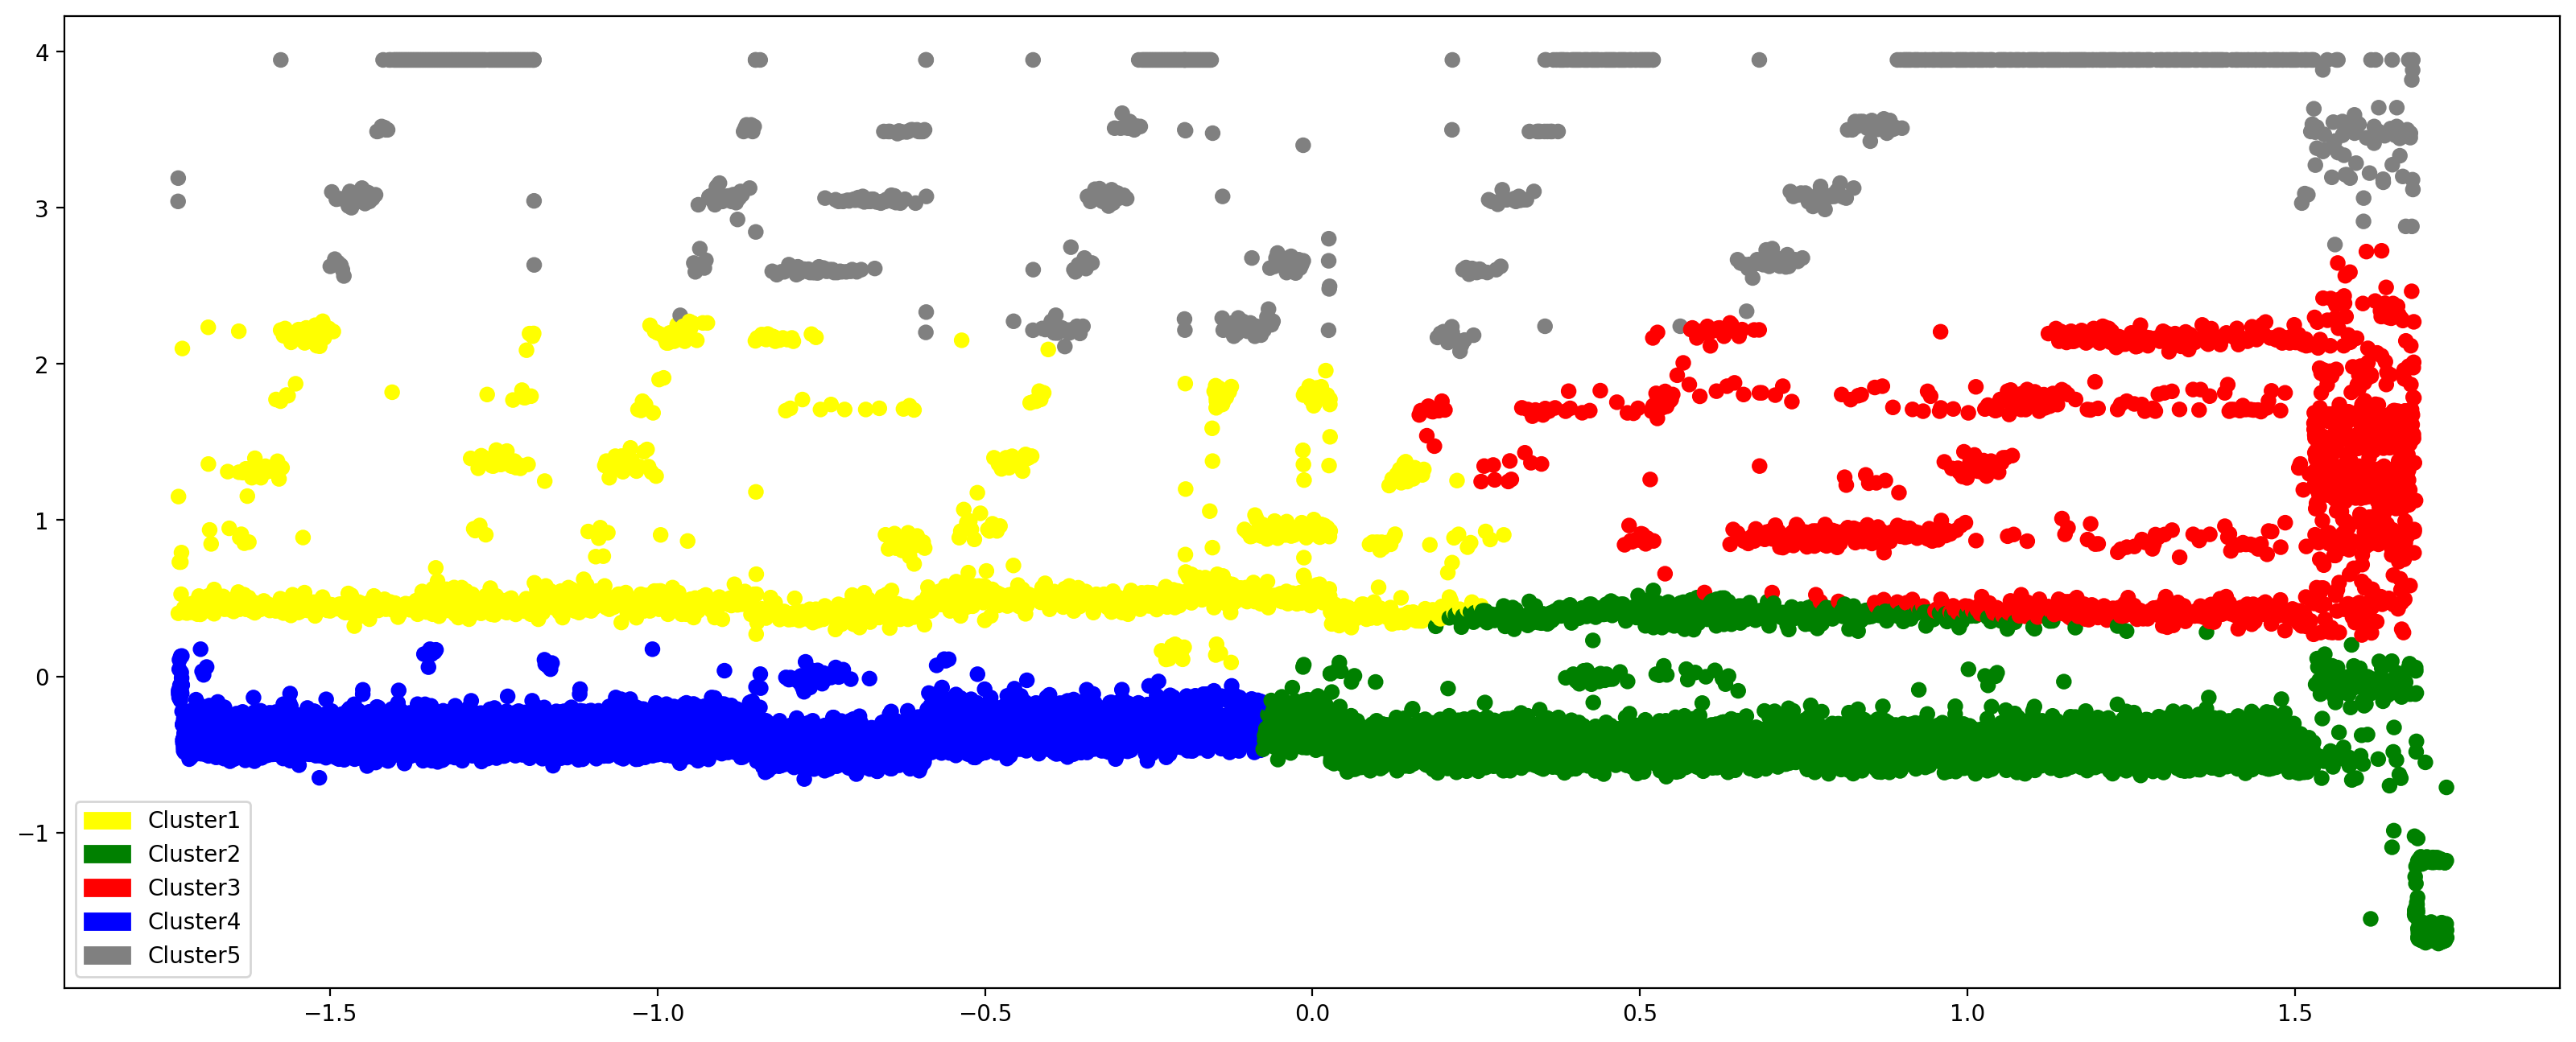

In [14]:
fig, ax = pyplot.subplots(figsize=(20,8),dpi=200)
colors = {0:'yellow', 1:'green', 2:'red', 3:'blue', 4:'gray'}
p1 = Patch(color='yellow', label='Cluster1')
p2 = Patch(color='green', label='Cluster2')
p3 = Patch(color='red', label='Cluster3')
p4 = Patch(color='blue', label='Cluster4')
p5 = Patch(color='gray', label='Cluster5')
pyplot.legend(handles=[p1,p2,p3,p4,p5])
ax.scatter(X[0], X[1] , c=CPU_df["KMean_Cluster"].apply(lambda x: colors[x]))
pyplot.show()

We noticed each section are well distributed and their seperate very good. There are no clear overlap. The green, blue, yellow and red are very concentrated.

In [15]:
def KMD(data, kmean, dist):
    for i in range(0,len(X)):
        dist.at[i]=linalg.norm(array(X.loc[i])-kmean.cluster_centers_[kmean.labels_[i]-1]) 
    return (dist)
distance = pd.Series()
distance = KMD(X, bestkmeans, distance)

We will count each note distance to its center and determine which one is anoml.

In [16]:
numb = int(0.01*len(distance))
threshold = distance.nlargest(numb).min()
print("The number of outliers is {}".format(numb))
print("The threshold is {}".format(threshold))

The number of outliers is 180
The threshold is 4.739933744413368


In [17]:
CPU_df['KMean_Anomaly'] = (distance >= threshold).astype(int)
CPU_df.head()

,timestamp,value,second,IsolationForest_Anomaly,KMean_Cluster,KMean_Anomaly
0,2014-05-14 01:14:00,85.835,1400030040,-1,4,0
1,2014-05-14 01:19:00,88.167,1400030340,-1,4,0
2,2014-05-14 01:24:00,44.595,1400030640,1,0,0
3,2014-05-14 01:29:00,56.282,1400030940,1,0,0
4,2014-05-14 01:34:00,36.534,1400031240,1,3,0


Plot the anomal data

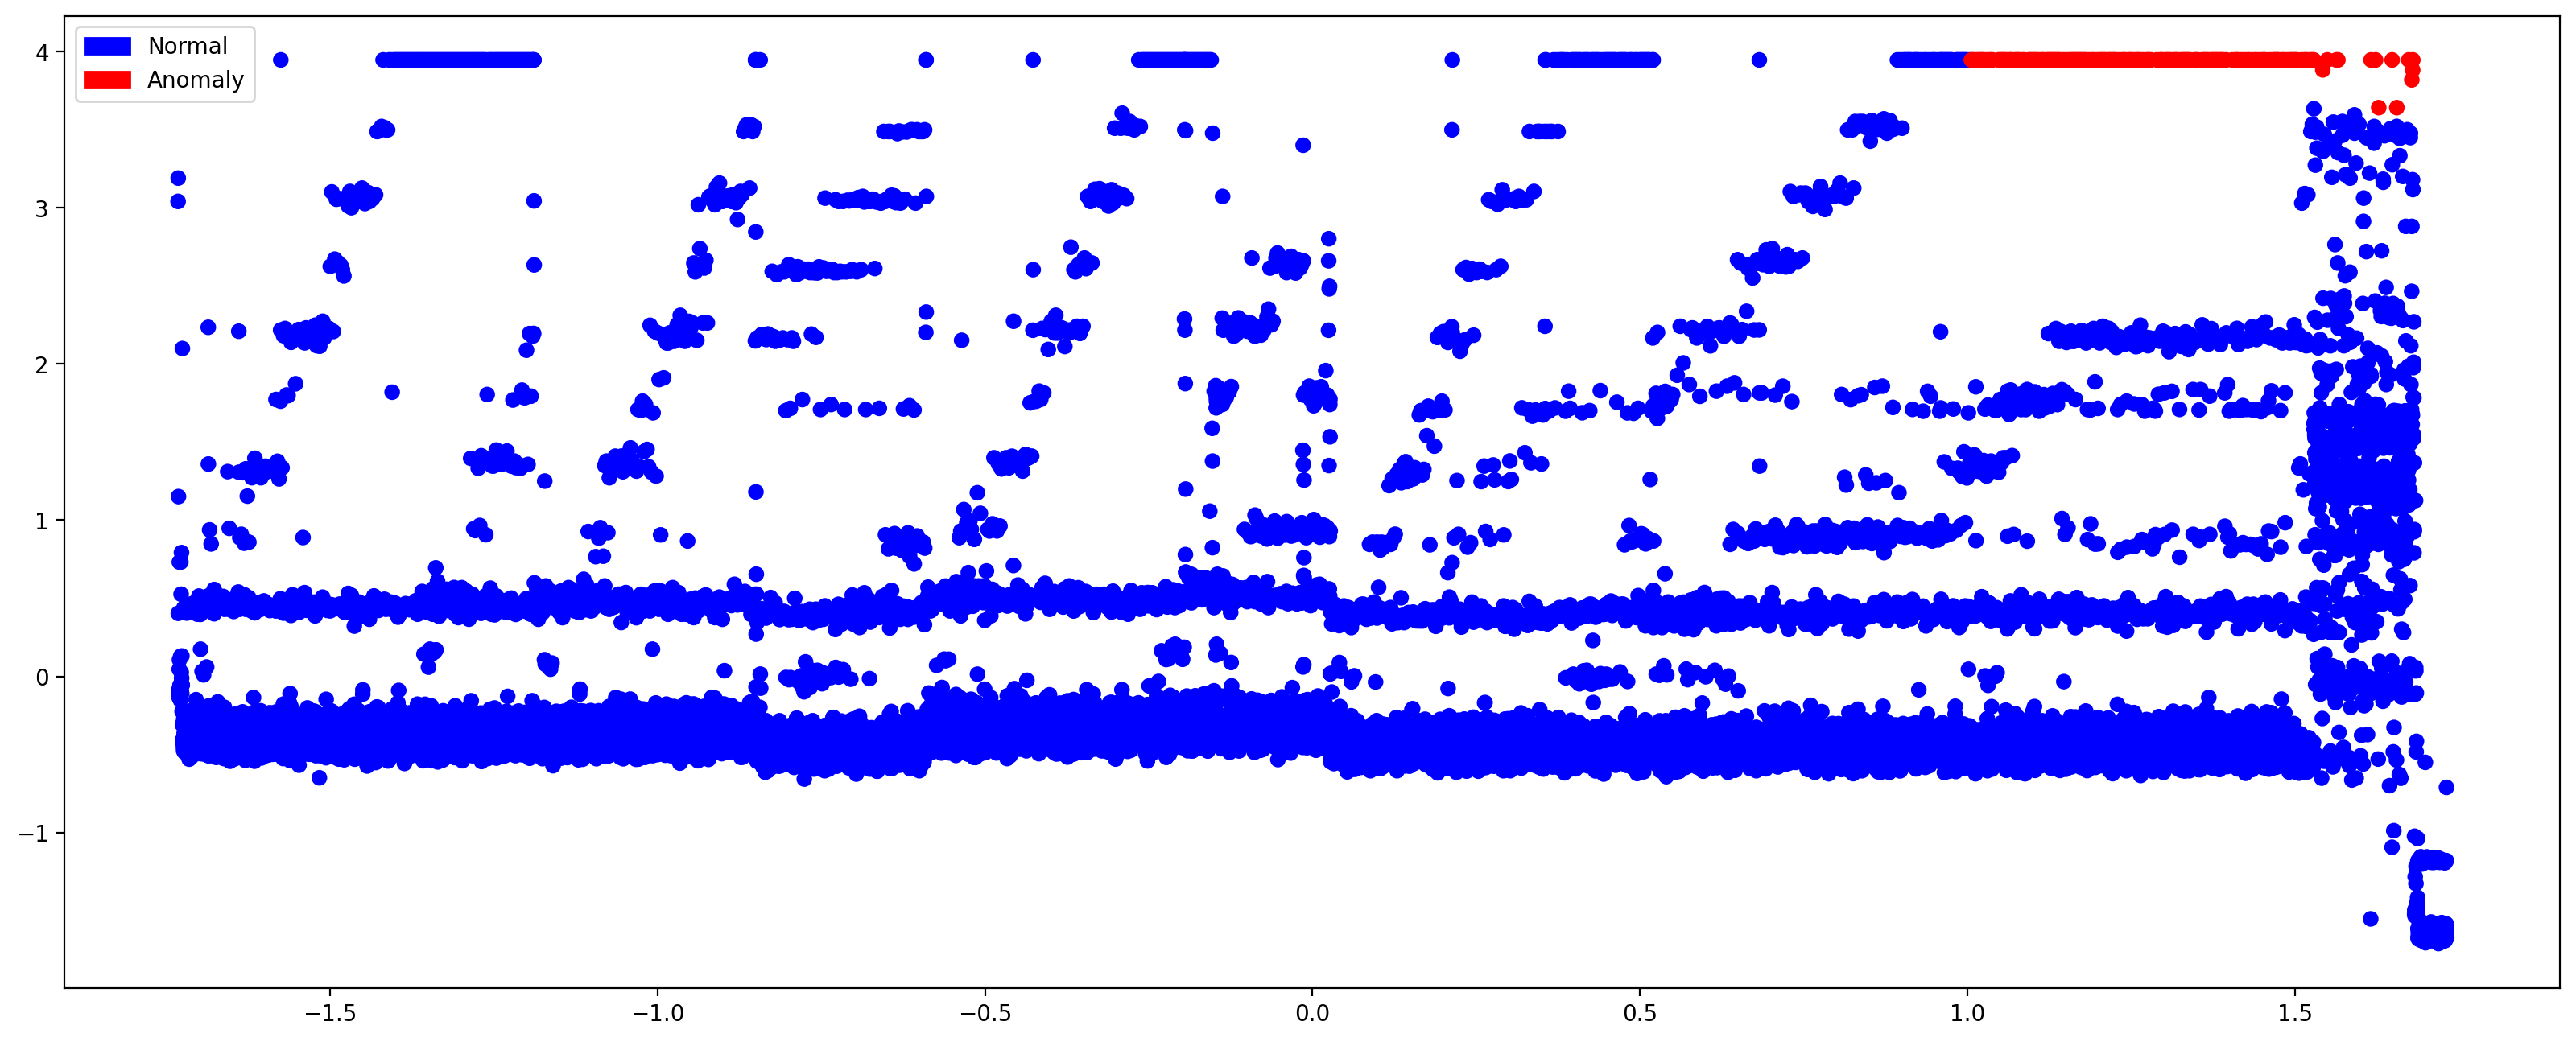

In [18]:
fig, ax = pyplot.subplots(figsize=(20,8),dpi=200)
colors = {0:'blue', 1:'red'}
p1 = Patch(color='blue', label='Normal')
p2 = Patch(color='red', label='Anomaly')
pyplot.legend(handles=[p1,p2])
ax.scatter(X[0], X[1] , c=CPU_df["KMean_Anomaly"].apply(lambda x: colors[x]))
pyplot.show()

The graph is very much like what I expected, the part at right buttom corner are anoml data is this model. 

## DBSCAN
Train the model

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

In [20]:
model = DBSCAN(eps=0.01)
predictions = model.fit_predict(X_norm)
CPU_df['DBSCAN_Anomaly'] =prediction
CPU_df.head()


,timestamp,value,second,IsolationForest_Anomaly,KMean_Cluster,KMean_Anomaly,DBSCAN_Anomaly
0,2014-05-14 01:14:00,85.835,1400030040,-1,4,0,-1
1,2014-05-14 01:19:00,88.167,1400030340,-1,4,0,-1
2,2014-05-14 01:24:00,44.595,1400030640,1,0,0,1
3,2014-05-14 01:29:00,56.282,1400030940,1,0,0,1
4,2014-05-14 01:34:00,36.534,1400031240,1,3,0,1


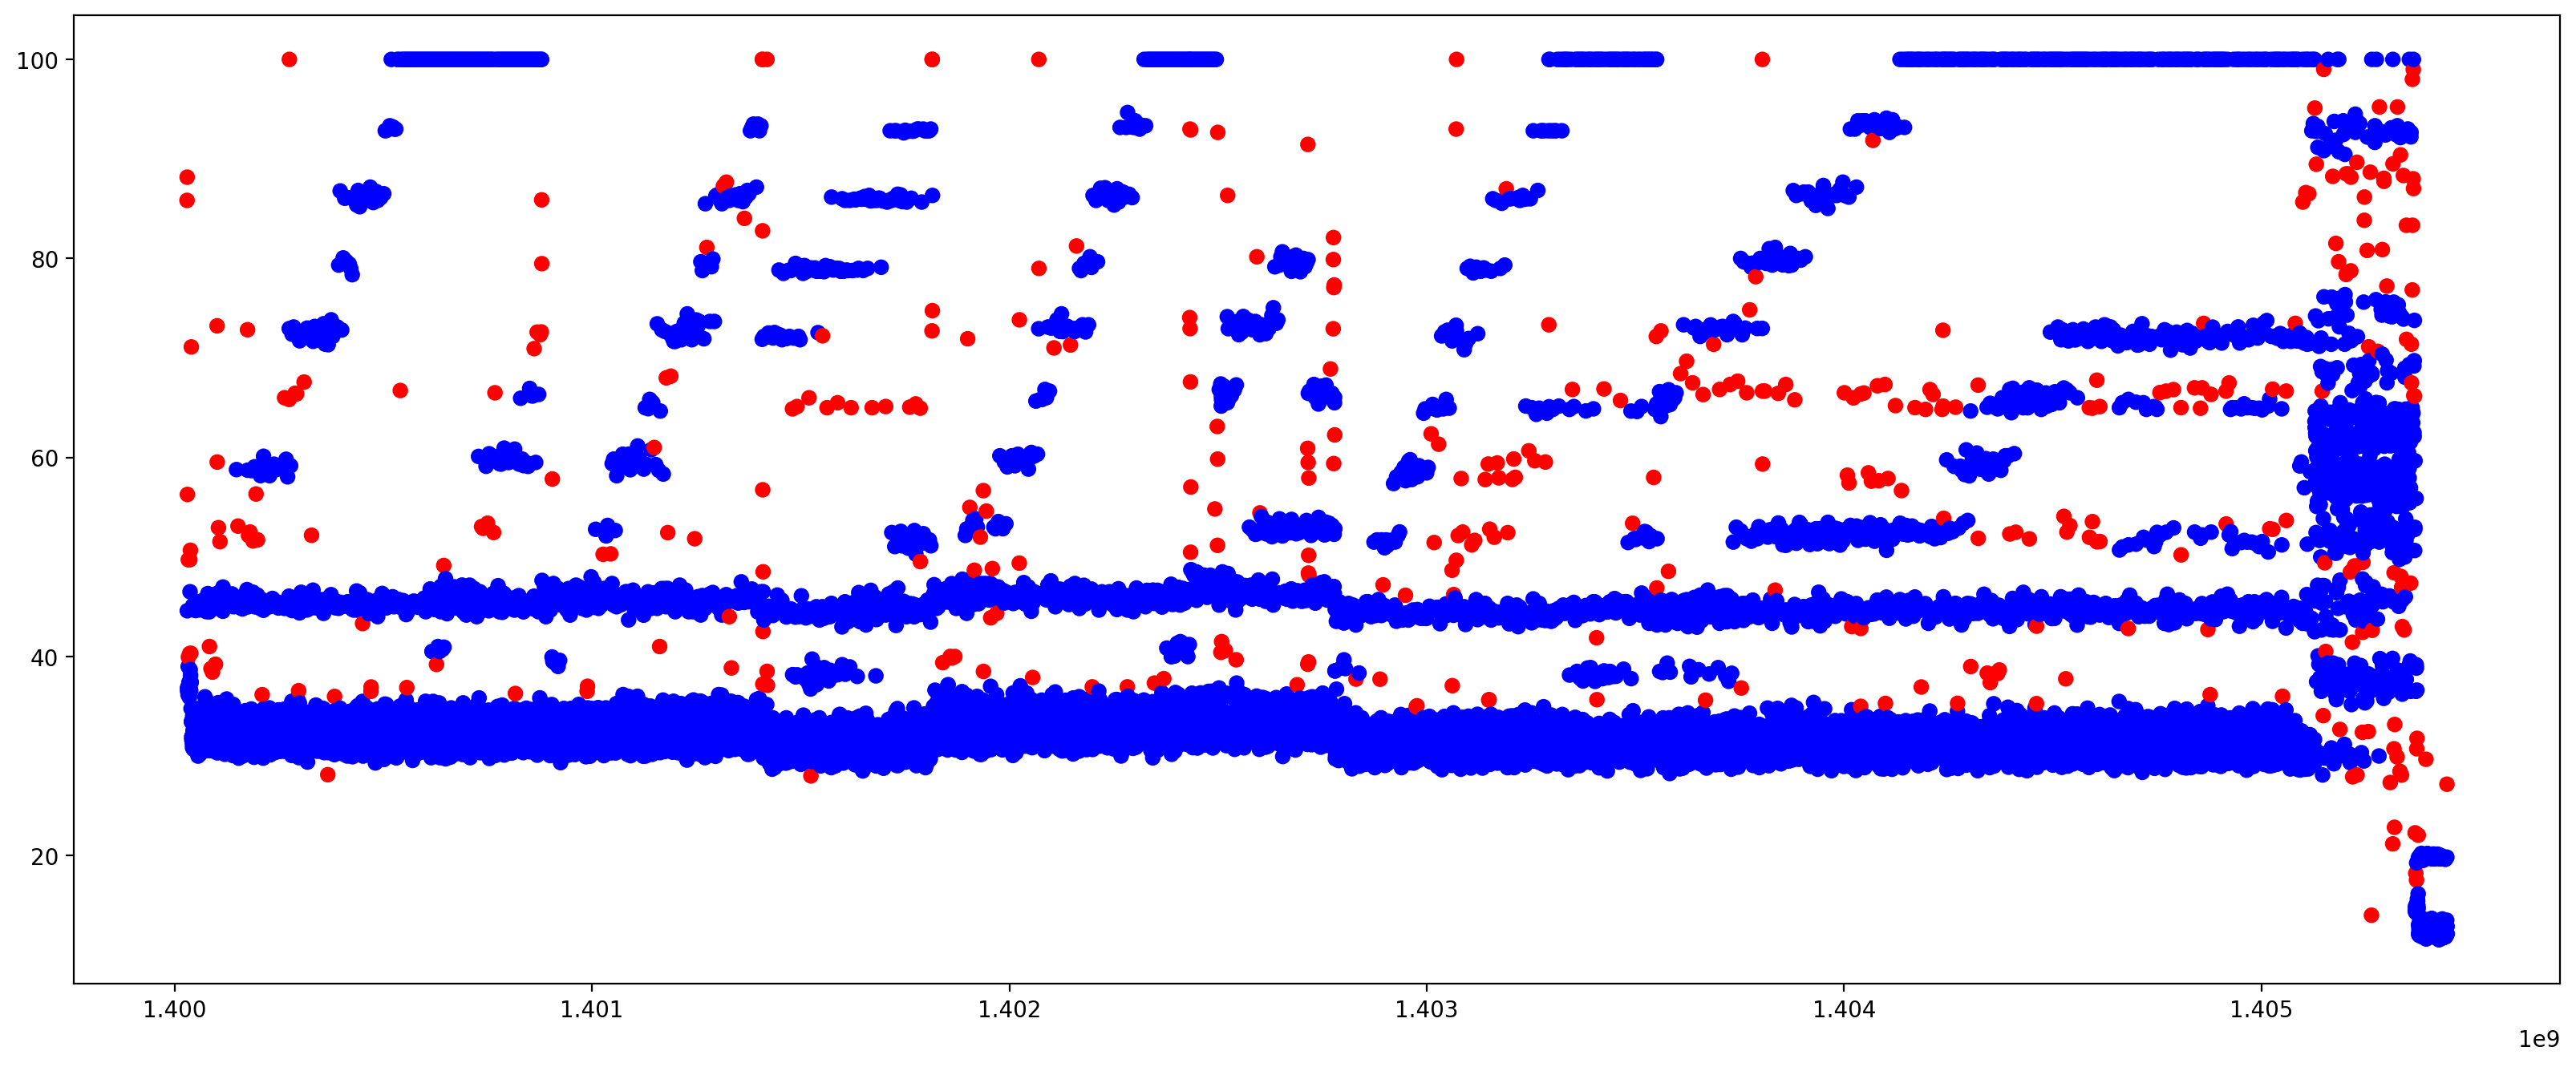

In [21]:
pyplot.figure(figsize=(20,8),dpi=200)
colors = np.array(list(map(lambda x: "red" if x == -1 else "blue", predictions)))
pyplot.scatter(b, a, c=colors)
pyplot.show()

In [22]:
anomaly = len(CPU_df.loc[CPU_df['DBSCAN_Anomaly']==-1])
print('Number of anomaly: {}'.format(anomaly))
print('Percentage of anomalies in data:{}'.format(anomaly*100/len(CPU_df)))

Number of anomaly: 177
Percentage of anomalies in data:0.9806094182825484


## Conclusion
The different model have different anomal data. I tried three kind of models: Isolation forest, Kmeans and DBSCAN. Isolation forest and Kmeans verified my initail conjecture. DBSCAN is quite hard to notice. We may assume the anomaly often happen at curve or spike joint. However, DBSCAN model bring up another possiblility. 